In this notebook we continue experiments with Support Vector Machine based models for identifying and mapping topographic landscapes. We continue with the same Eastern U.S. geography that was at the center of prior study. 

Preliminary results in applying the SVM to differentiate and classify the coastal plain from the upland are encouraging with classification accuracies exceeding 90%. 

The overarching assumption here continues to be that the coastal plain province, and by extension coastal plains in general, present topographic characteristics that differ geomorphically/geomorphometrically with the adjacent upland. Further, these differientiating characteristics can measured and used to build  classification model that distinguishes in some meaningful way, present a less topographically varied (i.e. rough) character than do the interior uplands [onto which the coastal plains abutt). Further, we assume that, in the presence of true assumptions, we can further identify, quantitatively model, and go on to map this difference and the two provinces--reliably. Repeatably. Maybe even globally!

**NOTE2 THESE DATA _ARE_ SLOPE CONSTRAINED: IN THIS NOTEBOOK WE ARE USING SLOPES ONLY IN THE RANGE FROM 0 TO (up to) 0.69 DEGREES (per Paris, Walsh, and Corbett, 2016)**

**Load Requisite Modules, Libraries, and Magics:**

In [2]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score   # not using
from sklearn.model_selection import KFold             # not using
from sklearn.model_selection import validation_curve  # not using
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline            # not using
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns

import sqlite3

sns.set()
%matplotlib inline

**Load the [labeled] sample observation data**

In [3]:
datapath='/Users/paulp/GoogleDrive/projects/GRASSData/USAtl_CoastalPlain_Prototype_LCC/user/sqlite/'
file='sqlite.db'

conn=sqlite3.connect(datapath+file)   # create a connection to the GRASS database file:

# load the contents of the vector point file: train_test_10k_pts into a pandas dataframe
# note that we are loading only those records whose elevation (z) is > 0 meters.
# note that we are also dropping all records that contain one or more missing (NaN) values.
# note that we are also selecting only the records where slopes are <= 0.69 degrees.
df = pd.read_sql_query('select * from train_test_10k_pts where z > 0.0 AND slope <=0.69', conn).dropna()

# build the standardized X features and y target arrays:
scaler = StandardScaler()
X=scaler.fit_transform(np.array(df[['z','slope','distance']]) )
y=np.array(df['label']) 
print(np.shape(y), np.shape(X))

(6147,) (6147, 3)


In [6]:
df.describe()

,cat,Easting,Northing,z,slope,distance,label
count,6147.000000,6147.000000,6147.000000,6147.000000,6147.000000,6147.000000,6147.000000
mean,8318.261591,-372251.008201,143678.865810,169.048479,0.230281,343207.701779,-0.345046
std,6720.151874,309423.324849,463156.494745,130.188610,0.200642,284962.760801,0.938662
min,8.000000,-901697.585983,-959789.872943,1.000000,0.000000,41.835533,-1.000000
25%,2601.500000,-608704.237746,-222931.819265,46.000000,0.050648,82071.997024,-1.000000
50%,5939.000000,-430708.278749,218983.051462,174.000000,0.182628,266070.431897,-1.000000
75%,16519.500000,-150714.635382,551918.915607,253.000000,0.380698,595762.496363,1.000000
max,19098.000000,579268.791966,814868.261764,1063.000000,0.689473,989776.652395,1.000000


**Plot the Sample Data--Premodeling (Elevation, Slope, Distance to Shore)**

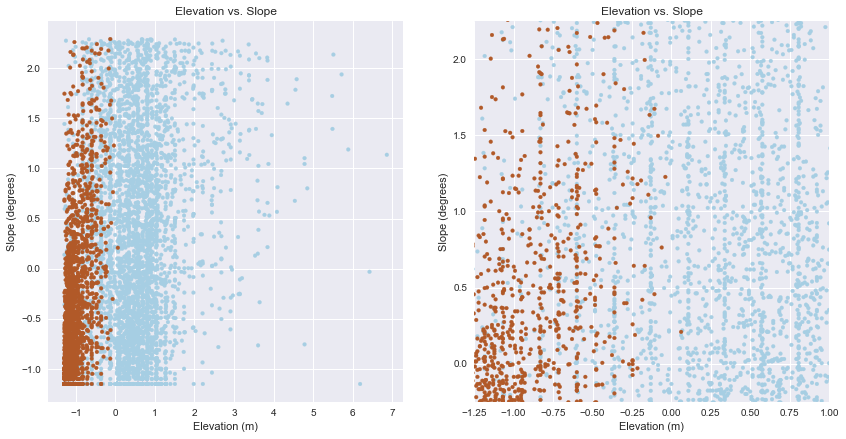

In [10]:
### Plots for Elevation vs Slope

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(14,7)) 

ax1.scatter(X[:,0],X[:,1], c=y, s=14, cmap=mpl.cm.Paired)
ax1.set_xlabel('Elevation (m)')
ax1.set_ylabel('Slope (degrees)')
ax1.set_title('Elevation vs. Slope')

ax2.scatter(X[:,0],X[:,1], c=y, s=14, cmap=mpl.cm.Paired)
ax2.set_xlim(-1.25, 1)
ax2.set_ylim(-0.25, 2.25)
ax2.set_xlabel('Elevation (m)')
ax2.set_ylabel('Slope (degrees)')
ax2.set_title('Elevation vs. Slope')

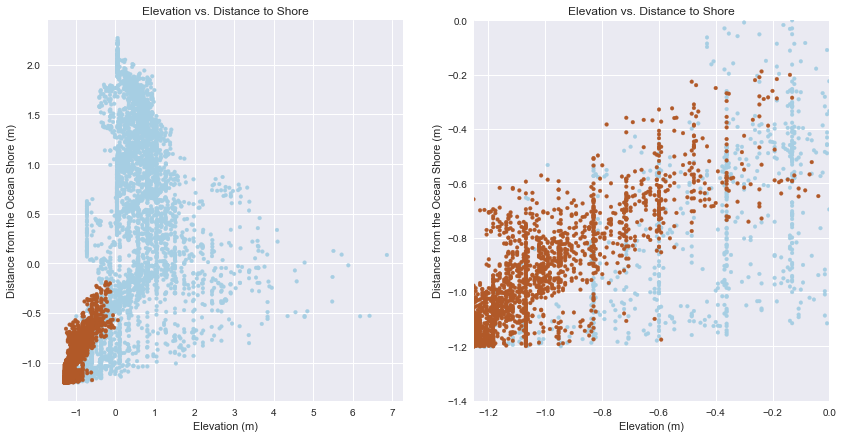

In [7]:
### Plots for Elevation vs Distance to the Ocean Shore

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(14,7)) 

ax1.scatter(X[:,0],X[:,2], c=y, s=14, cmap=mpl.cm.Paired)
ax1.set_xlabel('Elevation (m)')
ax1.set_ylabel('Distance from the Ocean Shore (m)')
ax1.set_title('Elevation vs. Distance to Shore')

ax2.scatter(X[:,0],X[:,2], c=y, s=14, cmap=mpl.cm.Paired)
ax2.set_xlim(-1.25, 0)
ax2.set_ylim(-1.4, 0)
ax2.set_xlabel('Elevation (m)')
ax2.set_ylabel('Distance from the Ocean Shore (m)')
ax2.set_title('Elevation vs. Distance to Shore')

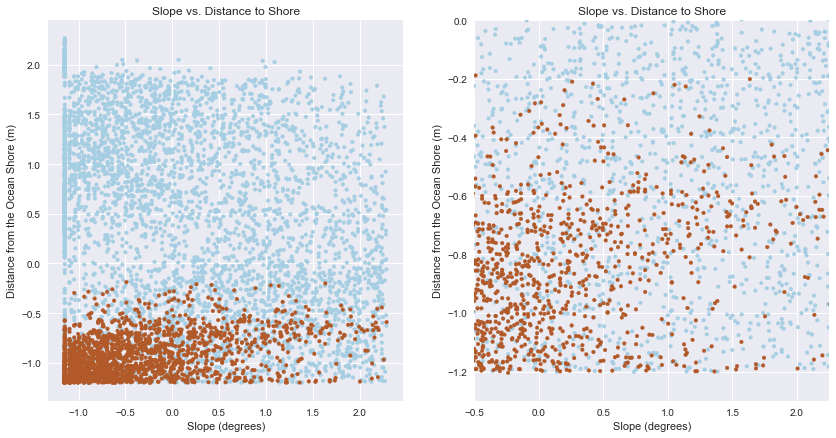

In [11]:
### Plots for Slope vs Distance to the Ocean Shore

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(14,7)) 

ax1.scatter(X[:,1],X[:,2], c=y, s=14, cmap=mpl.cm.Paired)
ax1.set_xlabel('Slope (degrees)')
ax1.set_ylabel('Distance from the Ocean Shore (m)')
ax1.set_title('Slope vs. Distance to Shore')

ax2.scatter(X[:,1],X[:,2], c=y, s=14, cmap=mpl.cm.Paired)
ax2.set_xlim(-0.5, 2.25)
ax2.set_ylim(-1.3, 0)
ax2.set_xlabel('Slope (degrees)')
ax2.set_ylabel('Distance from the Ocean Shore (m)')
ax2.set_title('Slope vs. Distance to Shore')

**Create the training and testing data subsets**

The training data is used to fit the Support Vector Machine (SVM) model (the SVM classifer is actually fit to the training data). We do initial testing and tuning of the model via cross-validation (coming next) and then "test" the model against the test data subset for generalization--its ability to predict using datasets of unknown classification.


The holdout split of the test data is typically 20% (Aurelien, Geron, 2017. Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. O-Reilly Media, Inc. Per Andrew Ng (Stanford U. Machine Learning Course): training 60%, validation 20%, testing 20%. Since we're doing kfold cross-validation
we don't need the validation set, so we'll stick with the 'Pareto' 80/20
rule! However...cross-validation and optimization on approximately 8000 sample points is sure to chew up lots of computing resources (O(N^3) actually) and so require a lot of time (perhaps days) to process. To get around this issue to some degree we will split the training data (Xtrain) in half and do the cross-validation and optimization on those fewer points. Once optimized hyper-parameters are in hand we can then train the SVC using those parameters against the full training set. 

In [12]:
holdout=0.2
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=holdout, random_state=42)

print('Total Sample Observations:', len(X))
print('Observations in training set:', len(Xtrain))
print('Observations in test set:', len(Xtest))

Total Sample Observations: 6147
Observations in training set: 4917
Observations in test set: 1230


**Cross-Validation and Parameter Tuning to Optimize the SVC**

We use cross-validation in order to identify optimal values for the hyperparameters that will define our SVM. The parameters of interest are: kernel (linear, polynmial, or radial basis), gamma (if a radial basis function kernel proves best), degree (if a polynomial kernel is the best fit), and C the tolerance for data points falling inside the hyperplane margins.

Note: some of the reporting code was copied, with modification, from the Sci-kit learn GridSearchCV documentation: http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html

In [13]:
%%time
print('Using', len(Xtrain), 'sample points for cross-validation')
parameters=[{'kernel':['rbf'], 'C':[1,10,100,1000], 'gamma':[7,8,9,10,11,12,14]}]

scores=['precision','recall']
for score in scores:
    print('Optimizing the SVC for %s' % score)
    cv = GridSearchCV(estimator=svm.SVC(C=1),param_grid=parameters, cv=5, n_jobs=-1, scoring='%s_macro' % score)
    cv.fit(Xtrain,ytrain)
    print("Best parameters set found on development set:")
    print()
    print(cv.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = cv.cv_results_['mean_test_score']
    stds = cv.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, cv.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = ytest, cv.predict(Xtest)
    print(classification_report(y_true, y_pred))
    print()

Using 4917 sample points for cross-validation
Optimizing the SVC for precision
Best parameters set found on development set:

{'gamma': 9, 'kernel': 'rbf', 'C': 1}

Grid scores on development set:

0.932 (+/-0.012) for {'gamma': 7, 'kernel': 'rbf', 'C': 1}
0.932 (+/-0.011) for {'gamma': 8, 'kernel': 'rbf', 'C': 1}
0.933 (+/-0.012) for {'gamma': 9, 'kernel': 'rbf', 'C': 1}
0.932 (+/-0.012) for {'gamma': 10, 'kernel': 'rbf', 'C': 1}
0.932 (+/-0.011) for {'gamma': 11, 'kernel': 'rbf', 'C': 1}
0.931 (+/-0.010) for {'gamma': 12, 'kernel': 'rbf', 'C': 1}
0.932 (+/-0.012) for {'gamma': 14, 'kernel': 'rbf', 'C': 1}
0.927 (+/-0.011) for {'gamma': 7, 'kernel': 'rbf', 'C': 10}
0.927 (+/-0.011) for {'gamma': 8, 'kernel': 'rbf', 'C': 10}
0.927 (+/-0.011) for {'gamma': 9, 'kernel': 'rbf', 'C': 10}
0.926 (+/-0.010) for {'gamma': 10, 'kernel': 'rbf', 'C': 10}
0.926 (+/-0.011) for {'gamma': 11, 'kernel': 'rbf', 'C': 10}
0.925 (+/-0.008) for {'gamma': 12, 'kernel': 'rbf', 'C': 10}
0.925 (+/-0.009) for {

**Create a Confusion Matrix**

Display a count of the number of observations correctly classified and number nor correctly classified for each class label

In [15]:
# create a confusion matrix to get a count of the number of observations correctly classified
# and the number NOT correctly classified:
#print(confusion_matrix(ytest,sv.predict(Xtest) ))
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_true,y_pred),index=[-1,1], columns=[-1,1]  )) 
print()
print(cv.best_estimator_.score(Xtest, ytest).round(3))
print()
print('Geometric Mean:' )
print( )

Confusion Matrix:
     -1    1
-1  804   38
 1   30  358

0.945

Geometric Mean:



**Generate (learn) an SVM model**

Using the best estimators from the GridSearch cross-validation build a new (optimized) SVC with the training data set.

In [16]:
%%time
sv=svm.SVC(C=100, kernel='rbf', gamma=12).fit(Xtrain,ytrain)
print('Number of support vectors (class -1 class 1):', sv.n_support_)

Number of support vectors (class -1 class 1): [289 315]
CPU times: user 1.12 s, sys: 9.58 ms, total: 1.13 s
Wall time: 1.16 s


**Classify the test data set**

In [17]:
y_pred = sv.predict(Xtest)
print(y_pred)
np.shape(y_pred)

[ 1 -1 -1 ...,  1 -1 -1]


(1230,)

**Plot the resulting classified points (predicted) in '_cool_' 3-D**